Import Libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)


Load Dataset

In [3]:
DATA_PATH = Path('/content/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df = pd.read_csv(DATA_PATH)
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


EDA

In [4]:
df.info()
df.describe()

# Attrition class balance
df['Attrition'].value_counts(), df['Attrition'].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

(Attrition
 No     1233
 Yes     237
 Name: count, dtype: int64,
 Attrition
 No     0.838776
 Yes    0.161224
 Name: proportion, dtype: float64)

Preprocessing

In [5]:
# Create binary target: Yes = 1, No = 0
y = (df['Attrition'].str.strip().str.lower() == 'yes').astype(int)

# Define features: remove target + ID variable
X = df.drop(columns=['Attrition', 'EmployeeNumber'], errors='ignore')

# Numeric & categorical splitting
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# One-hot encoding
X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Sort columns for consistency
X_enc = X_enc.reindex(sorted(X_enc.columns), axis=1)

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.3, random_state=42, stratify=y
)

# Scale for LogReg, SVM, MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Evaluation Function

In [6]:
def evaluate_model(name, model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)

    # predictions
    y_pred = model.predict(Xte)

    # scoring
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(Xte)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_score = model.decision_function(Xte)
    else:
        y_score = y_pred

    return {
        'model': name,
        'accuracy': accuracy_score(yte, y_pred),
        'precision': precision_score(yte, y_pred),
        'recall': recall_score(yte, y_pred),
        'f1': f1_score(yte, y_pred),
        'roc_auc': roc_auc_score(yte, y_score),
        'estimator': model,
    }


Training All Six Models

In [10]:
results = []
feature_info = {}   # store coefficients + importances for later

# ============================================================
# LOGISTIC REGRESSION (scaled)
# ============================================================
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
lr_result = evaluate_model('Logistic Regression', log_reg,
                           X_train_scaled, X_test_scaled, y_train, y_test)
results.append(lr_result)

# ---- Logistic Regression Coefficients ----
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": log_reg.coef_[0]
}).sort_values("coefficient", ascending=False)

feature_info["Logistic Regression"] = coef_df

print("\nTop 10 Positive Coefficients (Higher Attrition Risk):")
display(coef_df.head(10))

print("\nTop 10 Negative Coefficients (Lower Attrition Risk):")
display(coef_df.tail(10))


# ============================================================
# DECISION TREE (unscaled)
# ============================================================
dt = DecisionTreeClassifier(random_state=42, max_depth=6)
dt_result = evaluate_model('Decision Tree', dt,
                           X_train, X_test, y_train, y_test)
results.append(dt_result)

# ---- Feature Importances ----
dt_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": dt.feature_importances_
}).sort_values("importance", ascending=False)

feature_info["Decision Tree"] = dt_importance

print("\nDecision Tree — Top Features:")
display(dt_importance.head(10))


# ============================================================
# RANDOM FOREST (unscaled)
# ============================================================
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf_result = evaluate_model('Random Forest', rf,
                           X_train, X_test, y_train, y_test)
results.append(rf_result)

rf_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

feature_info["Random Forest"] = rf_importance

print("\nRandom Forest — Top Features:")
display(rf_importance.head(10))


# ============================================================
# GRADIENT BOOSTING (unscaled)
# ============================================================
gb = GradientBoostingClassifier(random_state=42)
gb_result = evaluate_model('Gradient Boosting', gb,
                           X_train, X_test, y_train, y_test)
results.append(gb_result)

gb_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": gb.feature_importances_
}).sort_values("importance", ascending=False)

feature_info["Gradient Boosting"] = gb_importance

print("\nGradient Boosting — Top Features:")
display(gb_importance.head(10))


# ============================================================
# SVM (scaled)
# ============================================================
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_result = evaluate_model('SVM (RBF)', svm_rbf,
                            X_train_scaled, X_test_scaled, y_train, y_test)
results.append(svm_result)

# SVM has no feature_importances_
feature_info["SVM (RBF)"] = "No feature importances available."


# ============================================================
# NEURAL NETWORK (scaled)
# ============================================================
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                    max_iter=500, random_state=42)
mlp_result = evaluate_model('Neural Network (MLP)', mlp,
                            X_train_scaled, X_test_scaled, y_train, y_test)
results.append(mlp_result)

feature_info["Neural Network (MLP)"] = "No feature importances available."


# ============================================================
# RESULTS TABLE
# ============================================================
results_df = pd.DataFrame([
    {k:v for k,v in r.items() if k!="estimator"}
    for r in results
])

results_df.sort_values("roc_auc", ascending=False)




Top 10 Positive Coefficients (Higher Attrition Risk):


,feature,coefficient
33,OverTime_Yes,0.868609
1,BusinessTravel_Travel_Frequently,0.689218
20,JobRole_Laboratory Technician,0.670609
44,YearsSinceLastPromotion,0.616252
25,JobRole_Sales Executive,0.613567
26,JobRole_Sales Representative,0.558015
32,NumCompaniesWorked,0.491335
29,MaritalStatus_Single,0.401519
2,BusinessTravel_Travel_Rarely,0.395709
6,DistanceFromHome,0.356526



Top 10 Negative Coefficients (Lower Attrition Risk):


,feature,coefficient
11,EducationField_Other,-0.339968
17,JobInvolvement,-0.347294
36,RelationshipSatisfaction,-0.372609
8,EducationField_Life Sciences,-0.389313
10,EducationField_Medical,-0.397371
0,Age,-0.421568
27,JobSatisfaction,-0.430645
43,YearsInCurrentRole,-0.439430
14,EnvironmentSatisfaction,-0.450709
39,TotalWorkingYears,-0.459928



Decision Tree — Top Features:


,feature,importance
39,TotalWorkingYears,0.198064
30,MonthlyIncome,0.134302
33,OverTime_Yes,0.091207
0,Age,0.086875
32,NumCompaniesWorked,0.061626
38,StockOptionLevel,0.061307
3,DailyRate,0.059236
14,EnvironmentSatisfaction,0.057777
16,HourlyRate,0.050557
41,WorkLifeBalance,0.042273



Random Forest — Top Features:


,feature,importance
30,MonthlyIncome,0.076927
0,Age,0.064927
39,TotalWorkingYears,0.058418
3,DailyRate,0.050027
31,MonthlyRate,0.047930
16,HourlyRate,0.045603
42,YearsAtCompany,0.045536
6,DistanceFromHome,0.042166
32,NumCompaniesWorked,0.038253
45,YearsWithCurrManager,0.037263



Gradient Boosting — Top Features:


,feature,importance
30,MonthlyIncome,0.124778
39,TotalWorkingYears,0.087659
33,OverTime_Yes,0.085136
0,Age,0.072358
3,DailyRate,0.054459
45,YearsWithCurrManager,0.052657
38,StockOptionLevel,0.051968
32,NumCompaniesWorked,0.043052
14,EnvironmentSatisfaction,0.039951
41,WorkLifeBalance,0.037186


,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.879819,0.725000,0.408451,0.522523,0.820404
4,SVM (RBF),0.861678,0.857143,0.169014,0.282353,0.810011
3,Gradient Boosting,0.843537,0.531250,0.239437,0.330097,0.784088
2,Random Forest,0.832200,0.428571,0.126761,0.195652,0.767568
5,Neural Network (MLP),0.834467,0.479167,0.323944,0.386555,0.731024
1,Decision Tree,0.800454,0.270270,0.140845,0.185185,0.585002


ROC Curves

<Figure size 800x600 with 0 Axes>

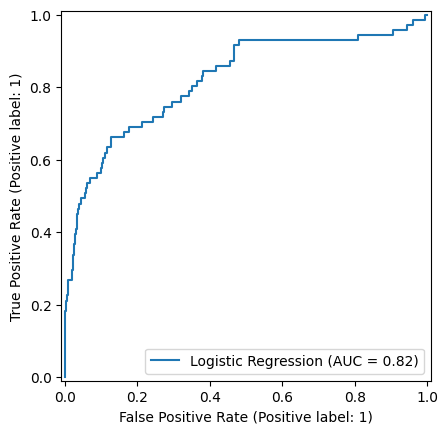

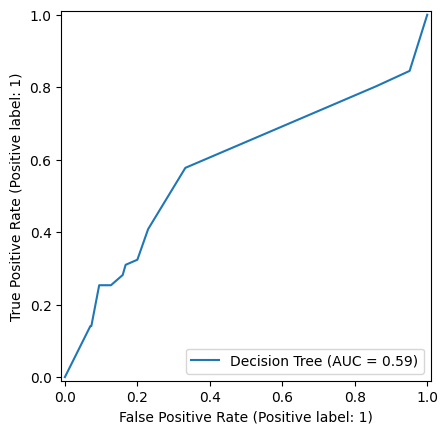

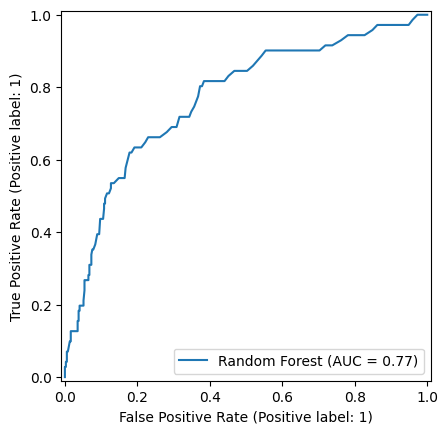

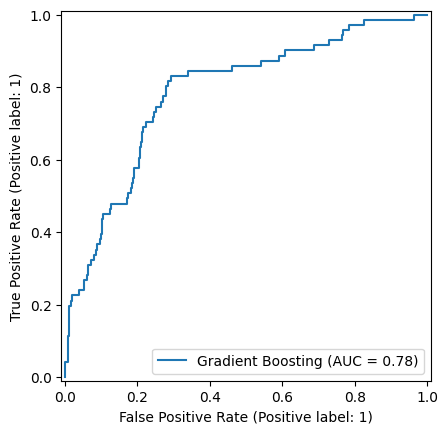

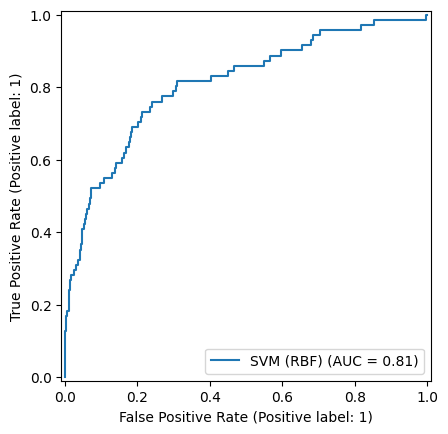

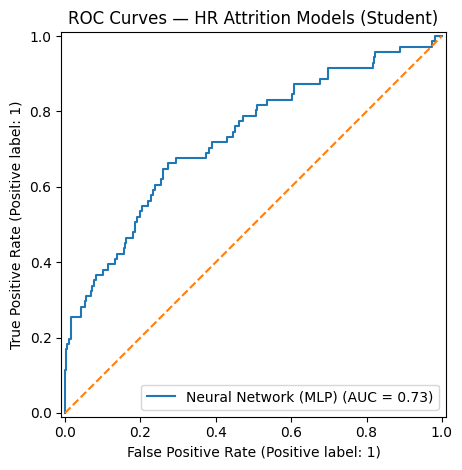

In [8]:
plt.figure(figsize=(8,6))

for r in results:
    est = r['estimator']
    name = r['model']

    Xte = X_test_scaled if name in [
        'Logistic Regression', 'SVM (RBF)', 'Neural Network (MLP)'
    ] else X_test

    if hasattr(est, 'predict_proba'):
        y_score = est.predict_proba(Xte)[:,1]
    elif hasattr(est, 'decision_function'):
        y_score = est.decision_function(Xte)
    else:
        continue

    RocCurveDisplay.from_predictions(y_test, y_score, name=name)

plt.plot([0,1],[0,1],'--')
plt.title('ROC Curves — HR Attrition Models (Student)')
plt.tight_layout()
plt.show()


Confusion Matrix

In [9]:
for r in results:
    est = r['estimator']
    name = r['model']

    Xte = X_test_scaled if name in [
        'Logistic Regression', 'SVM (RBF)', 'Neural Network (MLP)'
    ] else X_test

    y_pred = est.predict(Xte)

    print("\nModel:", name)
    print(confusion_matrix(y_test, y_pred))



Model: Logistic Regression
[[359  11]
 [ 42  29]]

Model: Decision Tree
[[343  27]
 [ 61  10]]

Model: Random Forest
[[358  12]
 [ 62   9]]

Model: Gradient Boosting
[[355  15]
 [ 54  17]]

Model: SVM (RBF)
[[368   2]
 [ 59  12]]

Model: Neural Network (MLP)
[[345  25]
 [ 48  23]]
